In [1]:
def add_src_and_logger(is_renkolab, save_dir):
    import sys
    from pathlib import Path
    import os
    import logging 
    src_path = Path.home() / "work" / "fco2diffusion" / "src"
    if str(src_path) not in sys.path:
        sys.path.insert(0, str(src_path))

    if is_renkolab:
        DATA_PATH = '/home/jovyan/work/datapolybox/'
    else:
        DATA_PATH = '../data/training_data/'
    
    if (save_dir is not None) and (not os.path.exists(save_dir)):
        os.makedirs(save_dir)

    if save_dir is None:
        logging.basicConfig(
            level=logging.INFO, 
            format='%(asctime)s - %(levelname)s - %(message)s'
            )
    else:
        logging.basicConfig(
            filename=save_dir+'training.log',
            filemode='a',
            level=logging.INFO, 
            format='%(asctime)s - %(levelname)s - %(message)s'
            )
    return DATA_PATH, logging

is_renkolab = True
save_dir = None
DATA_PATH, logger = add_src_and_logger(is_renkolab, save_dir)

In [3]:
from diffusers import DDPMScheduler, UNet1DModel
from fco2models.models import MLP, UNet2DModelWrapper, Unet2DClassifierFreeModel
import torch
import json
from fco2models.ueval import load_model

# load model
save_path = '../models/cfree1_mini/'
model_path = 'e_200.pt'
model_class = Unet2DClassifierFreeModel#lambda **model_params: Unet2DClassifierFreeModel(model_params, keep_channels=[0, 1, 2, 13], num_channels=14)#UNet2DModelWrapper#


model, noise_scheduler, params, losses = load_model(save_path, model_path, model_class, training_complete=True)
print("Model loaded")

Model loaded


In [4]:
import pandas as pd
import numpy as np
from fco2models.utraining import prep_df, make_monthly_split, get_segments_random, get_segments, get_context_mask, normalize_dss, get_stats_df
df = pd.read_parquet(DATA_PATH + "SOCAT_1982_2021_grouped_colloc_augm_bin.pq")
df = prep_df(df, bound=True)[0]
df['sst_clim'] += 273.15
df['sst_anom'] = df['sst_cci'] - df['sst_clim']
df['sss_anom'] = df['sss_cci'] - df['sss_clim']
df['chl_anom'] = df['chl_globcolour'] - df['chl_clim']
df['ssh_anom'] = df['ssh_sla'] - df['ssh_clim']
df['mld_anom'] = df['mld_dens_soda'] - df['mld_clim']
#map expocode column to int
expocode_map = df['expocode'].unique()
expocode_map = {expocode: i for i, expocode in enumerate(expocode_map)}
df['expocode_id'] = df['expocode'].map(expocode_map ) 
print(df.columns)

2025-06-25 13:51:28,761 - WARNING - mkdir -p failed for path /home/jovyan/.cache/matplotlib: [Errno 13] Permission denied: '/home/jovyan/.cache/matplotlib'
2025-06-25 13:51:28,763 - WARNING - Matplotlib created a temporary cache directory at /tmp/matplotlib-f6m6ydx5 because there was an issue with the default path (/home/jovyan/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2025-06-25 13:51:29,548 - INFO - generated new fontManager
2025-06-25 13:51:36,089 - INFO - salinity stacking
2025-06-25 13:51:36,135 - INFO - adding positional and temporal encodings
2025-06-25 13:51:37,738 - INFO - add climatology data
2025-06-25 13:51:46,900 - INFO - adding xco2 data
2025-06-25 13:51:51,523 - INFO - adding seamask data
2025-06-25 13:51:55,493 - INFO - adding climatology data
2025-06-25 13:52:20,016 - INFO - adding climatology data
2025-06-25

Index(['index', 'expocode', 'window_id', 'time_1d', 'lat', 'lon', 'sal',
       'sst_deg_c', 'pppp_hpa', 'woa_sss', 'ncep_slp_hpa', 'dist_to_land_km',
       'fco2rec_uatm', 'fco2rec_flag', 'time', 'year', 'temp_soda',
       'salt_soda', 'mld_dens_soda', 'lon_soda', 'lat_soda', 'depth_soda',
       'time_soda', 'sst_cci', 'sst_cci_uncertainty', 'ice_cci', 'time_sstcci',
       'lat_sstcci', 'lon_sstcci', 'interpolated', 'bin_id', 'segment_id',
       'ssh_adt', 'ssh_sla', 'lat_sshcm', 'lon_sshcm', 'time_sshcm',
       'chl_globcolour', 'chl_globcolour_uncert', 'chl_globcolour_flags',
       'time_chlgc', 'lat_chlgc', 'lon_chlgc', 'sss_cci',
       'sss_cci_random_error', 'lat_ssscci', 'lon_ssscci', 'time_ssscci',
       'day_of_year', 'sin_day_of_year', 'cos_day_of_year', 'sin_lat',
       'sin_lon_cos_lat', 'cos_lon_cos_lat', 'sin_lon', 'cos_lon', 'is_north',
       'co2_clim8d', 'xco2', 'seamask', 'chl_clim', 'chl_filled_clim',
       'dayofyear_clim', 'lat_clim', 'lon_clim', 'mld_c

In [5]:
# print(df.fco2rec_uatm.max(), df.fco2rec_uatm.min())

mask_train, mask_val, mask_test = make_monthly_split(df)
df_train = df[df.expocode.map(mask_train)]
df_val = df[df.expocode.map(mask_val)]
df_test = df[df.expocode.map(mask_test)]
print(df_train.fco2rec_uatm.max(), df_train.fco2rec_uatm.min())


target = "fco2rec_uatm"
predictors = params["predictors"]
#predictors = predictors[1:] # REMOVE AFTERWRADS
coords = ['expocode_id', 'window_id']
all_cols = predictors + coords
cols = [target] + all_cols

train_stats = get_stats_df(df_train, [target] + predictors)


def prep_for_eval(df, predictors, coords):
    target = "fco2rec_uatm"
    all_cols = [target] + predictors + coords
    n_coords = len(coords)
    segment_df = df.groupby("expocode").apply(
        lambda x: get_segments(x, all_cols),
        include_groups=False,
    )
    ds = np.concatenate(segment_df.values, axis=0)
    ds_input = ds[:, :-n_coords, :]  # remove expocode and window_id
    ds_index = ds[:, -n_coords:, :]
    return ds_input, ds_index


train_ds, train_index = prep_for_eval(df_train, predictors, coords)
val_ds, val_index = prep_for_eval(df_val, predictors, coords)
test_ds, test_index = prep_for_eval(df_test, predictors, coords)

print(f"train_ds shape: {train_ds.shape}, val_ds shape: {val_ds.shape}, test_ds shape: {test_ds.shape}")
train_context_mask, val_context_mask, test_context_mask = get_context_mask([train_ds, val_ds, test_ds])
train_ds = train_ds[train_context_mask]
train_index = train_index[train_context_mask]
val_ds = val_ds[val_context_mask]
val_index = val_index[val_context_mask]
test_ds = test_ds[test_context_mask]
test_index = test_index[test_context_mask]
print(f"removing context nans")
print(f"train_ds shape: {train_ds.shape}, val_ds shape: {val_ds.shape}, test_ds shape: {test_ds.shape}")

mode = params["mode"]
train_ds_norm, val_ds_norm, test_ds_norm = normalize_dss([train_ds.copy(), val_ds.copy(), test_ds.copy()], train_stats, mode, ignore=[])

# def add_fco2_mask(ds):
#     not_nan_mask = (~np.isnan(ds[:, 0:1, :])).astype(np.float32)
#     return np.concatenate([ds, not_nan_mask], axis=1)

# train_ds = add_fco2_mask(train_ds)
# val_ds = add_fco2_mask(val_ds)
# test_ds = add_fco2_mask(test_ds)

# count nans in first column of the dataset
print(f"train_ds shape: {train_ds.shape}, val_ds shape: {val_ds.shape}, test_ds shape: {test_ds.shape}")


Splitting data into train/val/test with parameters: month_step=7, val_offset=3, leave_out_2021=False
399.96630867451955 -390.85729311489627


2025-06-25 13:52:43,929 - INFO - Means: [-29.70872864691208, 0.14358897507190704, -0.2891390323638916, 1.3008071184158325, -0.35649824142456055, 37.01298522949219, 290.6070861816406, 32.85774230957031, -0.6113056540489197, 0.41975662112236023, 1.411604881286621, 390.3531455026237, -18.608415603637695]
2025-06-25 13:52:43,931 - INFO - Stds: [56.62324526132157, 1.0396103858947754, 1.379338026046753, 1.6470690965652466, 0.5963964462280273, 62.51891326904297, 9.572793960571289, 6.4218549728393555, 0.5078334808349609, 0.5917670130729675, 0.3734084665775299, 17.15055241582259, 45.36433410644531]
2025-06-25 13:52:43,932 - INFO - Mins: [-390.85729311489627, -14.535430908203125, -38.41282653808594, -1.7192974090576172, -2.9997119903564453, -2.9107136726379395, 271.3144836425781, 5.5685930252075195, -2.636031150817871, -1.505947232246399, 0.0, 334.0219236315376, -222.32705688476562]
2025-06-25 13:52:43,933 - INFO - Maxs: [399.96630867451955, 19.119049072265625, 26.47848892211914, 63.047290802001

train_ds shape: (61164, 13, 64), val_ds shape: (11896, 13, 64), test_ds shape: (12229, 13, 64)
removing context nans
train_ds shape: (42225, 13, 64), val_ds shape: (8348, 13, 64), test_ds shape: (8667, 13, 64)
train_ds shape: (42225, 13, 64), val_ds shape: (8348, 13, 64), test_ds shape: (8667, 13, 64)


In [6]:
if losses is None:
    print("No losses found, training incomplete")
else:
    train_losses = losses['train_losses']
    val_losses = losses['val_losses']
    # print epoch with minimum loss
    print("Epoch with minimum training loss: ", np.argmin(train_losses))
    print("Minimum training loss: ", np.min(train_losses))
    
    val_losses_mean = np.mean(val_losses, axis=1)
    print("Epoch with minimum validation loss: ", np.argmin(val_losses_mean))
    print("Minimum validation loss: ", np.min(val_losses_mean))

Epoch with minimum training loss:  180
Minimum training loss:  0.07882759888112867
Epoch with minimum validation loss:  182
Minimum validation loss:  0.15197811965816513


In [7]:
stats = {
    "train_maxs": params["train_maxs"],
    "train_mins": params["train_mins"],
    "train_means": params["train_means"],
    "train_stds": params["train_stds"],
}

In [8]:
train_stats['maxs'], params['train_maxs']

([399.96630867451955,
  19.119049072265625,
  26.47848892211914,
  63.04729080200195,
  1.5959644317626953,
  3775.63671875,
  304.902099609375,
  39.907958984375,
  1.8424890041351318,
  1.9580572843551636,
  2.9559805393218994,
  422.77308803094166,
  186.73130798339844],
 [399.96630867451955,
  19.119049072265625,
  26.47848892211914,
  63.04729080200195,
  1.5959644317626953,
  3775.63671875,
  304.902099609375,
  39.907958984375,
  1.8424890041351318,
  1.9580572843551636,
  2.9559805393218994,
  422.77308803094166,
  186.73130798339844])

In [9]:
assert np.allclose(train_stats['maxs'], params['train_maxs'], atol=1e0)
assert np.allclose(train_stats['mins'], params['train_mins'], atol=1e0)
assert np.allclose(train_stats['means'], params['train_means'], atol=1e0)
assert np.allclose(train_stats['stds'], params['train_stds'], atol=1e0)

In [24]:
n_rec = 50
n_samples=None
train_ds = train_ds[:n_samples]
train_index = train_index[:n_samples]
val_ds = val_ds[:n_samples]
val_index = val_index[:n_samples]
test_ds = test_ds[:n_samples]
test_index = test_index[:n_samples]

In [25]:
from diffusers import DDIMScheduler
ddim_scheduler = DDIMScheduler(
    num_train_timesteps=noise_scheduler.config.num_train_timesteps,
    beta_schedule=noise_scheduler.config.beta_schedule,
    clip_sample_range=noise_scheduler.config.clip_sample_range,
    )
ddim_scheduler.set_timesteps(50)

In [26]:
from fco2models.utraining import full_denoise
from torch.utils.data import Dataset, DataLoader
import torch

val_context = val_ds_norm[:n_samples, 1:, :]
val_context_ds = torch.from_numpy(np.repeat(val_context, n_rec, axis=0)).float()
print("context_ds shape: ", val_context_ds.shape)
val_context_loader = DataLoader(val_context_ds, batch_size=512, shuffle=False)

model.set_w(1)
with torch.no_grad():
    # denoise the samples
    print("Denoising samples")
    val_samples_norm = full_denoise(model, ddim_scheduler, val_context_loader, jump=None, eta=0)

context_ds shape:  torch.Size([417400, 12, 64])
Denoising samples
Training on cuda


Inference: 100%|██████████| 816/816 [24:51<00:00,  1.83s/it, timestep=tensor(0)]  


In [14]:
test_context = test_ds_norm[:n_samples, 1:, :]
test_context_ds = torch.from_numpy(np.repeat(test_context, n_rec, axis=0)).float()
print("context_ds shape: ", test_context_ds.shape)
test_context_loader = DataLoader(test_context_ds, batch_size=512, shuffle=False)


with torch.no_grad():
    # denoise the samples
    print("Denoising samples")
    test_samples_norm = full_denoise(model, ddim_scheduler, test_context_loader, jump=None)

context_ds shape:  torch.Size([173340, 12, 64])
Denoising samples
Training on cuda


Inference: 100%|██████████| 339/339 [27:57<00:00,  4.95s/it, timestep=tensor(0)]  


In [ ]:
train_context = train_ds_norm[:n_samples, 1:, :]   
train_context_ds = torch.from_numpy(np.repeat(train_context, n_rec, axis=0)).float()
print("context_ds shape: ", train_context_ds.shape)
train_context_loader = DataLoader(train_context_ds, batch_size=512, shuffle=False)

with torch.no_grad():
    # denoise the samples
    print("Denoising samples")
    train_samples_norm = full_denoise(model, ddim_scheduler, train_context_loader, jump=20)

In [ ]:
train_samples_norm.shape, train_ds[:, 0:1, :].shape

In [58]:
from fco2models.ueval import get_error_stats, rescale
# get error stats for the training set
print("Training set error stats")

train_samples = rescale(
    train_samples_norm.copy(), stats, params['mode'], 
    ).reshape(-1, n_rec, 64)
train_error_dict = get_error_stats(
    train_samples, 
    train_ds[:, 0:1, :]
    )

Training set error stats


NameError: name 'train_samples_norm' is not defined

In [27]:
from fco2models.ueval import get_error_stats, rescale
# calculate the error statistics for the validation set
print("Validation set error stats")
val_samples = rescale(
    val_samples_norm.copy(), stats, params['mode'], 
    ).reshape(val_samples_norm.shape)
val_samples = val_samples.reshape(-1, n_rec, 64)
val_error_dict = get_error_stats(
    val_samples, 
    val_ds[:, 0:1, :]
    )

Validation set error stats
Error statistics:
RMSE: 22.5294
MAE: 12.8491
R2: 0.7664
Bias: -0.4905 ± 18.0723
Mean correlation: 0.3264 ± 0.4561


In [16]:
from fco2models.ueval import get_error_stats, rescale
# calculate the error statistics for the validation set
print("Test set error stats")
test_samples = rescale(
    test_samples_norm.copy(), stats, params['mode'], 
    ).reshape(test_samples_norm.shape)
test_samples = test_samples.reshape(-1, n_rec, 64)
test_error_dict = get_error_stats(
    test_samples, 
    test_ds[:, 0:1, :]
    )

Test set error stats
Error statistics:
RMSE: 22.9644
MAE: 13.6732
R2: 0.7615
Bias: -0.2523 ± 17.9384
Mean correlation: 0.2825 ± 0.4419


In [ ]:
import json
# save the error statistics to a json file in a error_stats.json in in the save_path
def to_float(edict):
    for key in edict.keys():
        edict[key] = float(edict[key])
    return edict
error_stats = {
    'train_error': to_float(train_error_dict),
    'val_error': to_float(val_error_dict)
}
with open(save_path+f'error_stats_{model_path}.json', 'w') as f:
    json.dump(error_stats, f, indent=4)

In [ ]:
train_samples.shape, val_samples.shape

In [ ]:
from fco2models.ueval import plot_samples
import matplotlib.pyplot as plt

ixs = np.random.choice(np.arange(0, 2000), 10, replace=False)
fig, axs = plt.subplots(len(ixs) // 5, 5, figsize=(20, len(ixs)), sharex=True, sharey=True)
for i, ax in zip(ixs, axs.flatten()):
    samples = train_samples[i, :, :]
    truth = train_ds[i, 0, :]
    plot_samples(ax, samples, truth, title=f"Sample {i}")

plt.show()

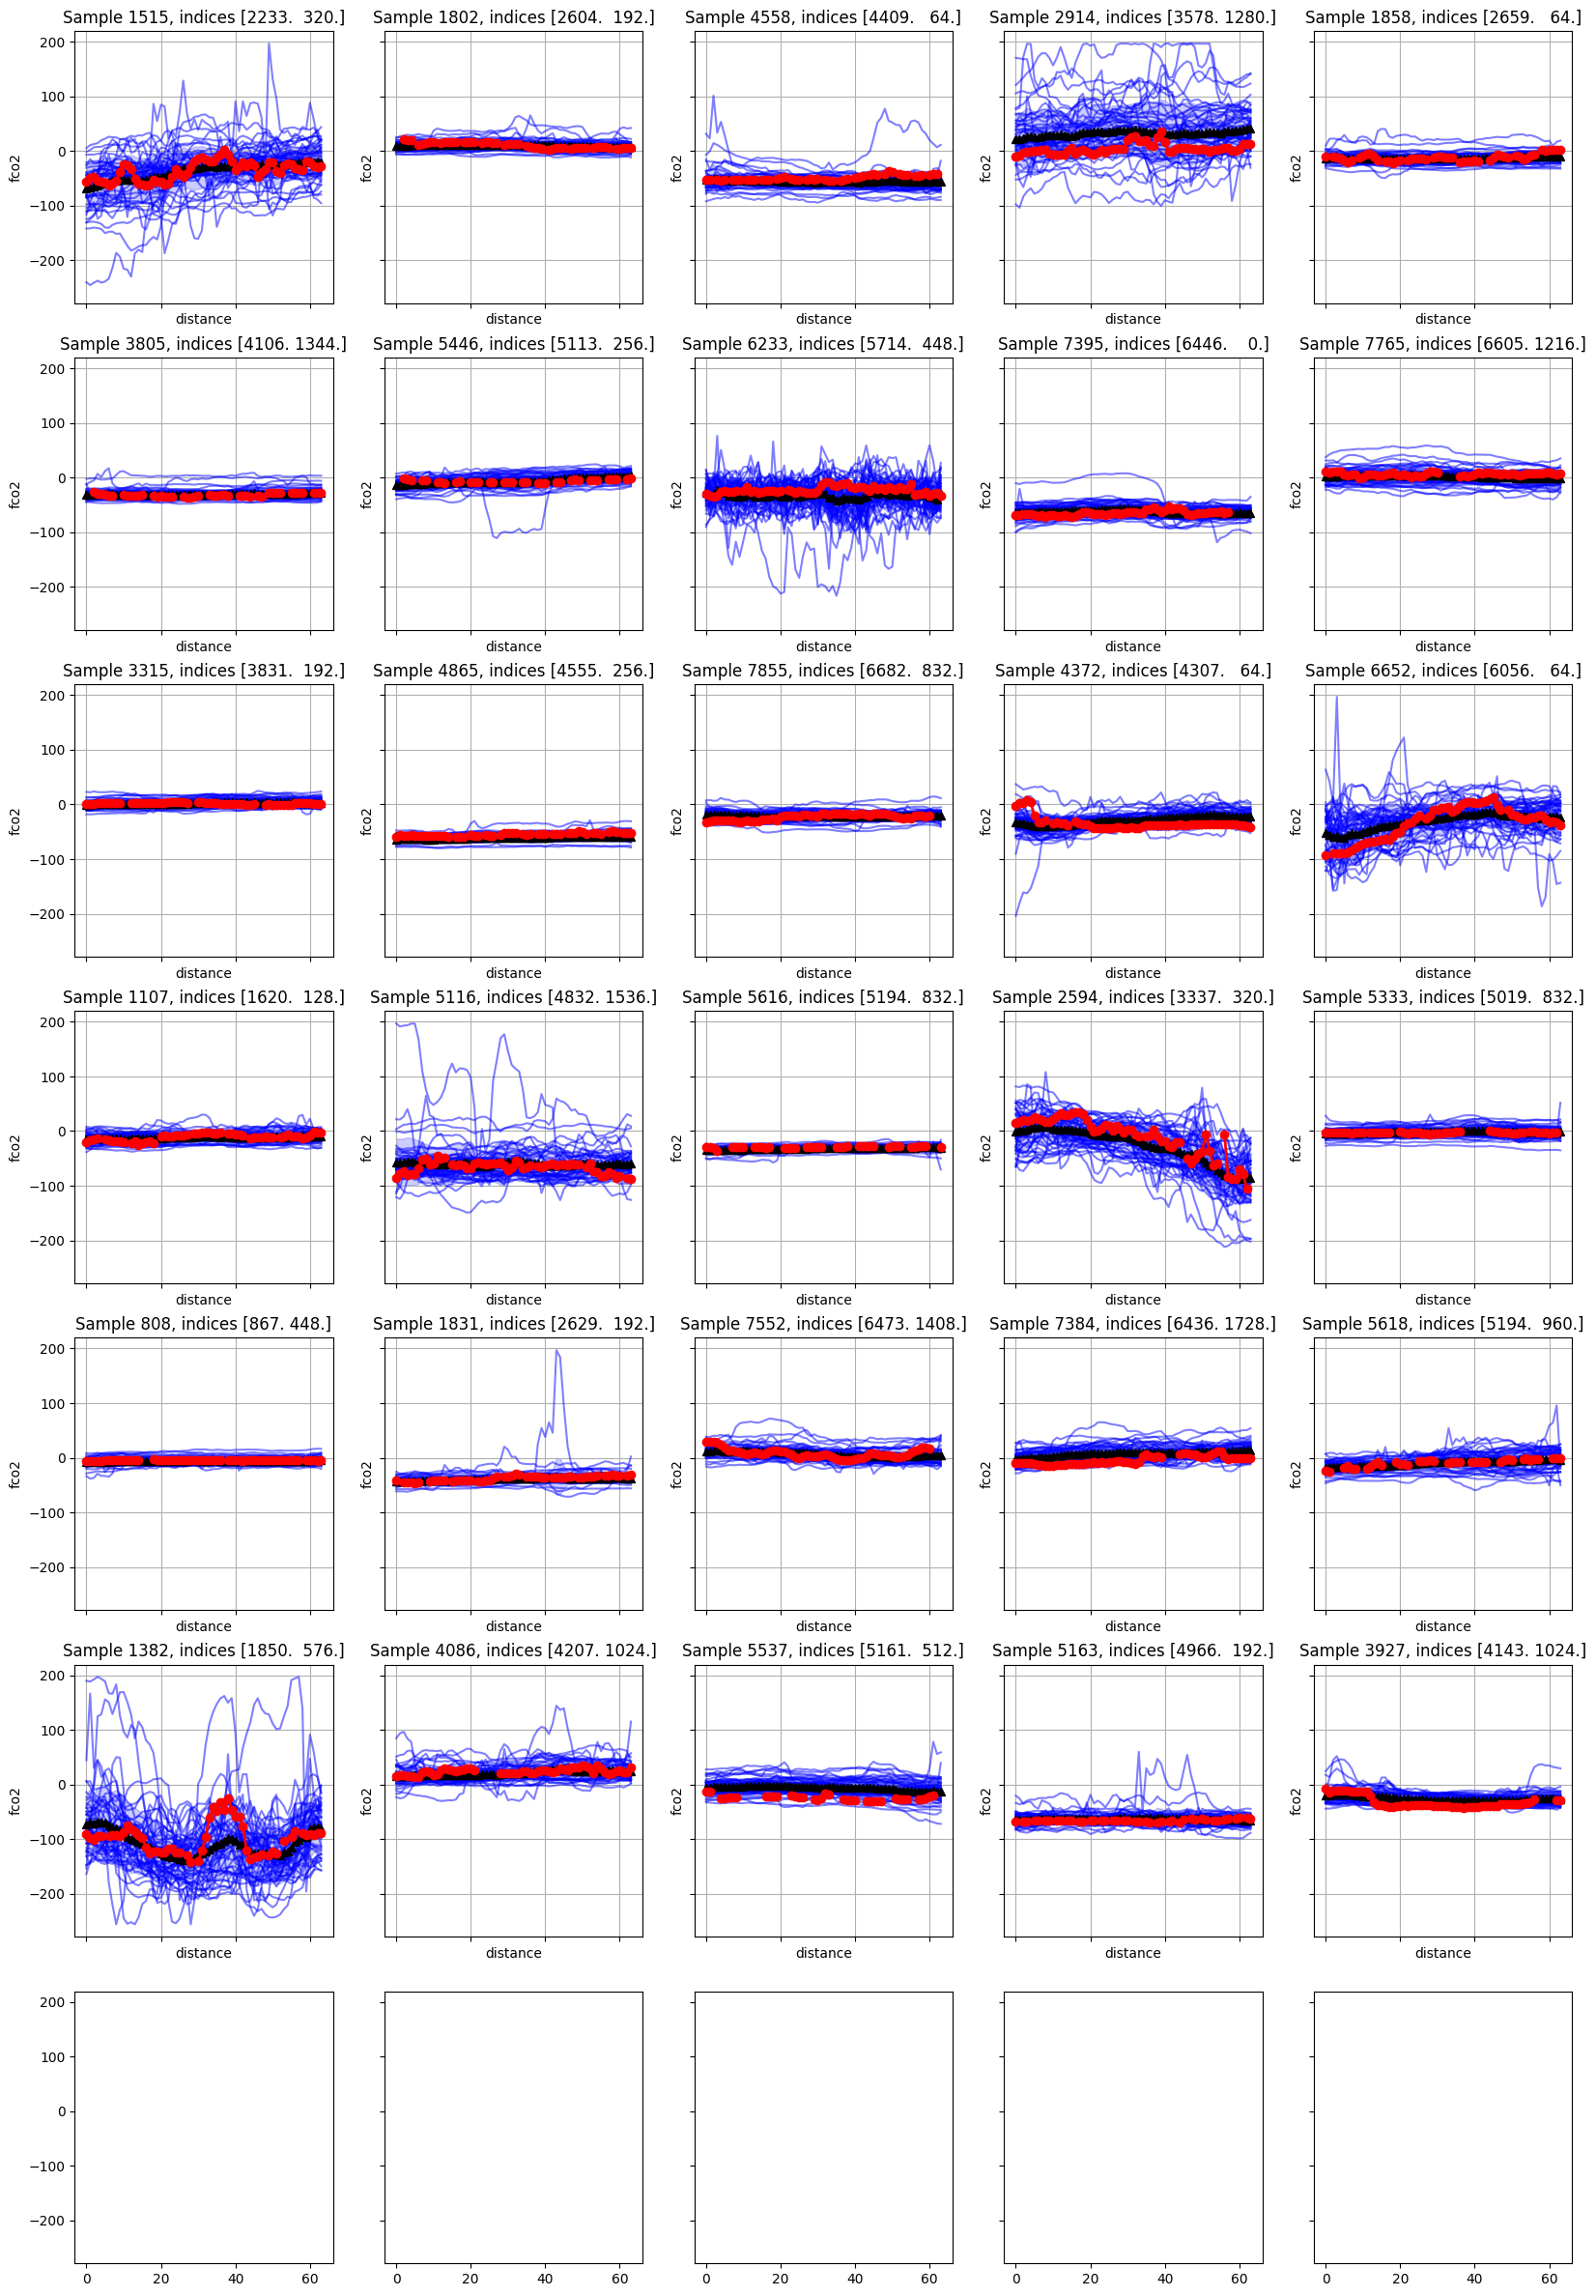

In [28]:
from fco2models.ueval import plot_samples
import matplotlib.pyplot as plt

ixs = np.random.choice(np.arange(0, 8000), 30, replace=False)

fig, axs = plt.subplots(len(ixs)//5 + 1, 5, figsize=(20, len(ixs)), sharex=True, sharey=True)
for i, ax in zip(ixs, axs.flatten()):
    samples = val_samples[i, :, :]
    truth = val_ds[i, 0, :]
    indices = val_index[i, :, 0]
    plot_samples(ax, samples, truth, title=f"Sample {i}, indices {indices}")

plt.show()

In [17]:
train_samples.shape, train_index.shape

NameError: name 'train_samples' is not defined

In [29]:
def samples_to_df(samples, index):
    samples_index = np.concatenate((samples, index), axis=1)
    # print(samples_index.shape)
    n_samples, n_cols, n_bins = samples_index.shape
    samples_index_flat = np.full((n_samples*n_bins, n_cols), np.nan)
    for i in range(samples_index.shape[1]):
        samples_index_flat[:, i] = samples_index[:, i, :].flatten()
    df = pd.DataFrame(samples_index_flat, columns=[f"sample_{i}" for i in range(n_rec)] + ['expocode_id', 'window_id'])
    df['expocode_id'] = df['expocode_id'].astype(int)
    df['window_id'] = df['window_id'].astype(int)
    df.set_index(['expocode_id', 'window_id'], inplace=True)
    return df

#train_samples_df = samples_to_df(train_samples, train_index)
val_samples_df = samples_to_df(val_samples, val_index)


In [30]:
df_val.index.names

FrozenList([None])

In [31]:
df_train.set_index(['expocode_id', 'window_id'], inplace=True)
train_df_pred = pd.concat([df_train, train_samples_df], axis=1)
train_df_pred = train_df_pred.reset_index()
df_train = df_train.reset_index()

KeyError: "None of ['expocode_id', 'window_id'] are in the columns"

In [33]:
df_val.set_index(['expocode_id', 'window_id'], inplace=True)
val_df_pred = pd.concat([df_val, val_samples_df], axis=1)
val_df_pred = val_df_pred.reset_index()
df_val = df_val.reset_index()

In [34]:
pred_columns = [f"sample_{i}" for i in range(n_rec)]
info_df = val_df_pred.loc[val_df_pred.seamask == 1]

In [35]:
pred_columns

['sample_0',
 'sample_1',
 'sample_2',
 'sample_3',
 'sample_4',
 'sample_5',
 'sample_6',
 'sample_7',
 'sample_8',
 'sample_9',
 'sample_10',
 'sample_11',
 'sample_12',
 'sample_13',
 'sample_14',
 'sample_15',
 'sample_16',
 'sample_17',
 'sample_18',
 'sample_19',
 'sample_20',
 'sample_21',
 'sample_22',
 'sample_23',
 'sample_24',
 'sample_25',
 'sample_26',
 'sample_27',
 'sample_28',
 'sample_29',
 'sample_30',
 'sample_31',
 'sample_32',
 'sample_33',
 'sample_34',
 'sample_35',
 'sample_36',
 'sample_37',
 'sample_38',
 'sample_39',
 'sample_40',
 'sample_41',
 'sample_42',
 'sample_43',
 'sample_44',
 'sample_45',
 'sample_46',
 'sample_47',
 'sample_48',
 'sample_49']

In [36]:
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from scipy.stats import pearsonr
def get_df_err_stats(df):
    seamask = df.seamask.astype(bool)
    fco2_nans = ~df.fco2rec_uatm.isna()
    pred_nans = ~df.sample_0.isna()
    mask = seamask & fco2_nans & pred_nans
    
    truth = df.loc[mask, "fco2rec_uatm"].values
    mean = df.loc[mask, pred_columns].mean(axis=1).values
    
    low = df.loc[mask, pred_columns].min(axis=1).values
    high = df.loc[mask, pred_columns].max(axis=1).values
    coverage = (truth >= low) & (truth <= high)
    
    rmse = root_mean_squared_error(truth, mean)
    r2 = r2_score(truth, mean)
    mae = mean_absolute_error(truth, mean)
    bias = (truth - mean).mean()
    
    print("Error statistics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2: {r2:.4f}")
    print(f"Bias: {bias:.4f}")
    print(f"Samples std: {df.loc[mask, pred_columns].std(axis=1).mean():.4f}")
    print(f"Coverage Probability: {coverage.mean():.4f}")
    print(f"Average Interval Width: {(high-low).mean():.4f} +- {(high-low).std():.4f}")
    print(f"Max Interval Width: {(high-low).max():.4f}")
    print(f"r2 between interval width and prediction error: {r2_score((truth-mean)**2, df.loc[mask, pred_columns].var(axis=1))}")
    print(f"Correlation variance and error: {pearsonr((truth-mean)**2, df.loc[mask, pred_columns].var(axis=1))[0]}")
    print(f"Ratio Error to interval width: {(mae/(high-low)).mean()}")
    

In [37]:
get_df_err_stats(val_df_pred)

Error statistics:
RMSE: 19.2350
MAE: 11.4899
R2: 0.7668
Bias: 0.0932
Samples std: 17.0135
Coverage Probability: 0.9696
Average Interval Width: 91.5643 +- 71.5519
Max Interval Width: 452.9860
r2 between interval width and prediction error: 0.1435252206982649
Correlation variance and error: 0.4036182440460016
Ratio Error to interval width: 0.19481356877102984


In [88]:
get_df_err_stats(train_df_pred)

Error statistics:
RMSE: 42.4258
MAE: 31.0707
R2: -0.1183
Bias: 6.5243
Samples std: 25.0409
Coverage Probability: 0.5673
Average Interval Width: 62.1721 +- 28.7652
Max Interval Width: 296.0465


In [38]:
group_cols = ['lat', 'lon']
info_df['predictions'] = info_df.loc[:, pred_columns].mean(axis=1)
info_df['uncert'] = info_df.loc[:, pred_columns].var(axis=1)
info_df['residuals'] = info_df['fco2rec_uatm'] - info_df['predictions']
# round group_cols to int
info_df[group_cols] = (info_df[group_cols] * 20).round(0) / 20.0
info_cols =  ['predictions', 'fco2rec_uatm', 'residuals', 'uncert', 'seamask', 'sst_cci', 'sst_deg_c', 'sss_cci' ,'sal'] 
plotting_data = info_df.loc[:, group_cols + info_cols].groupby(group_cols).mean().to_xarray().coarsen(lat=20, lon=20, boundary='pad').mean()

/tmp/ipykernel_2357/2936478343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_df['predictions'] = info_df.loc[:, pred_columns].mean(axis=1)
/tmp/ipykernel_2357/2936478343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_df['uncert'] = info_df.loc[:, pred_columns].var(axis=1)
/tmp/ipykernel_2357/2936478343.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

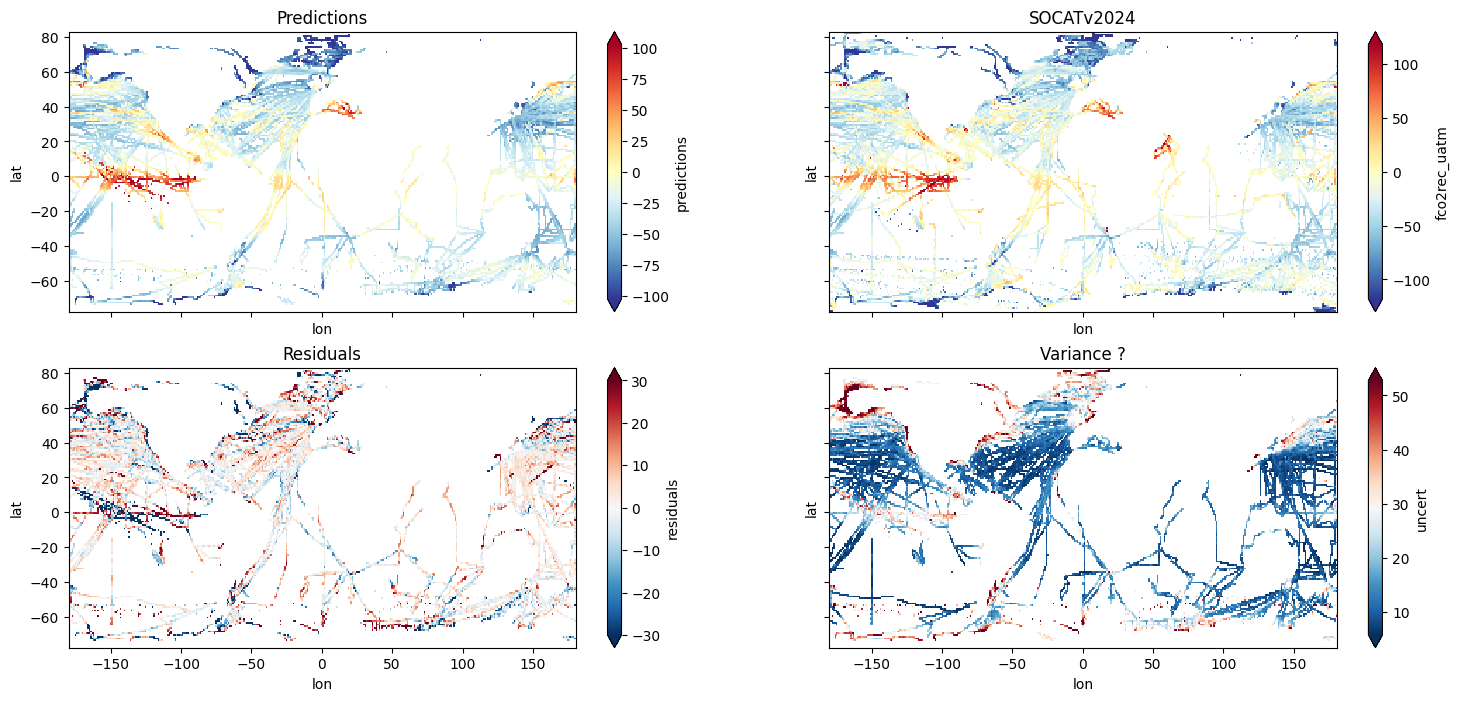

In [39]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(18, 8), sharex=True, sharey=True)
plotting_data.predictions.plot.imshow(robust=True, ax=axs[0, 0], cmap='RdYlBu_r',)
axs[0, 0].set_title('Predictions')
plotting_data.fco2rec_uatm.plot.imshow(robust=True, ax=axs[0, 1], cmap='RdYlBu_r')
axs[0, 1].set_title('SOCATv2024')
plotting_data.residuals.plot.imshow(robust=True, ax=axs[1, 0], cmap='RdBu_r', vmin=-30, vmax=30)
axs[1, 0].set_title('Residuals')
np.sqrt(plotting_data.uncert).plot.imshow(robust=True, ax=axs[1, 1], cmap='RdBu_r')
axs[1, 1].set_title('Variance ?')
plt.show()

In [91]:
# save the figure in the save_path
fig.savefig(save_path+f'predictions_{model_path}.png', dpi=200, bbox_inches='tight')

In [40]:
from sklearn import metrics
def plot_line_comparison(ax, y, yhat, **kwargs):
    from scipy.stats import pearsonr

    y.plot(ax=ax, **(kwargs | dict(label='SOCAT')),)
    yhat.plot(ax=ax, **kwargs)
    
    m = y.notnull() & yhat.notnull()
    y = y[m]
    yhat = yhat[m]
    
    metric_txt = (
        f"r2 = {metrics.r2_score(y, yhat):.2f}"
        f"\nRMSE = {metrics.root_mean_squared_error(y, yhat):.1f}"
        f"\nBias = {(yhat - y).mean():.1f}"
        f"\nPearson R = {pearsonr(y, yhat)[0]:.2f}")
    
    ax.text(0.01, 0.04, metric_txt, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom')
    
    ax.legend()
    ax.set_xticks(range(0, int(y.index.max()), 64))
    

def plot_diff_samples(ax, recs, truth, fill, **kwargs):
    windows = recs.index.get_level_values('window_id')
    recs = recs.values.T
    mean_pred = recs.mean(axis=0)
    uncert = recs.std(axis=0)
    ax.plot(windows, truth, **kwargs)
    ax.plot(windows, mean_pred, **kwargs)
    if fill:
        ax.fill_between(windows, mean_pred-uncert, mean_pred+uncert, alpha=0.2, color='b')
    else:
        ax.plot(windows, recs.T[:,:], **kwargs, alpha=0.5)


In [41]:
info_df.columns

Index(['expocode_id', 'window_id', 'index', 'expocode', 'time_1d', 'lat',
       'lon', 'sal', 'sst_deg_c', 'pppp_hpa',
       ...
       'sample_43', 'sample_44', 'sample_45', 'sample_46', 'sample_47',
       'sample_48', 'sample_49', 'predictions', 'uncert', 'residuals'],
      dtype='object', length=138)

Expocode: AG5W20141113
Expocode_id: 5725


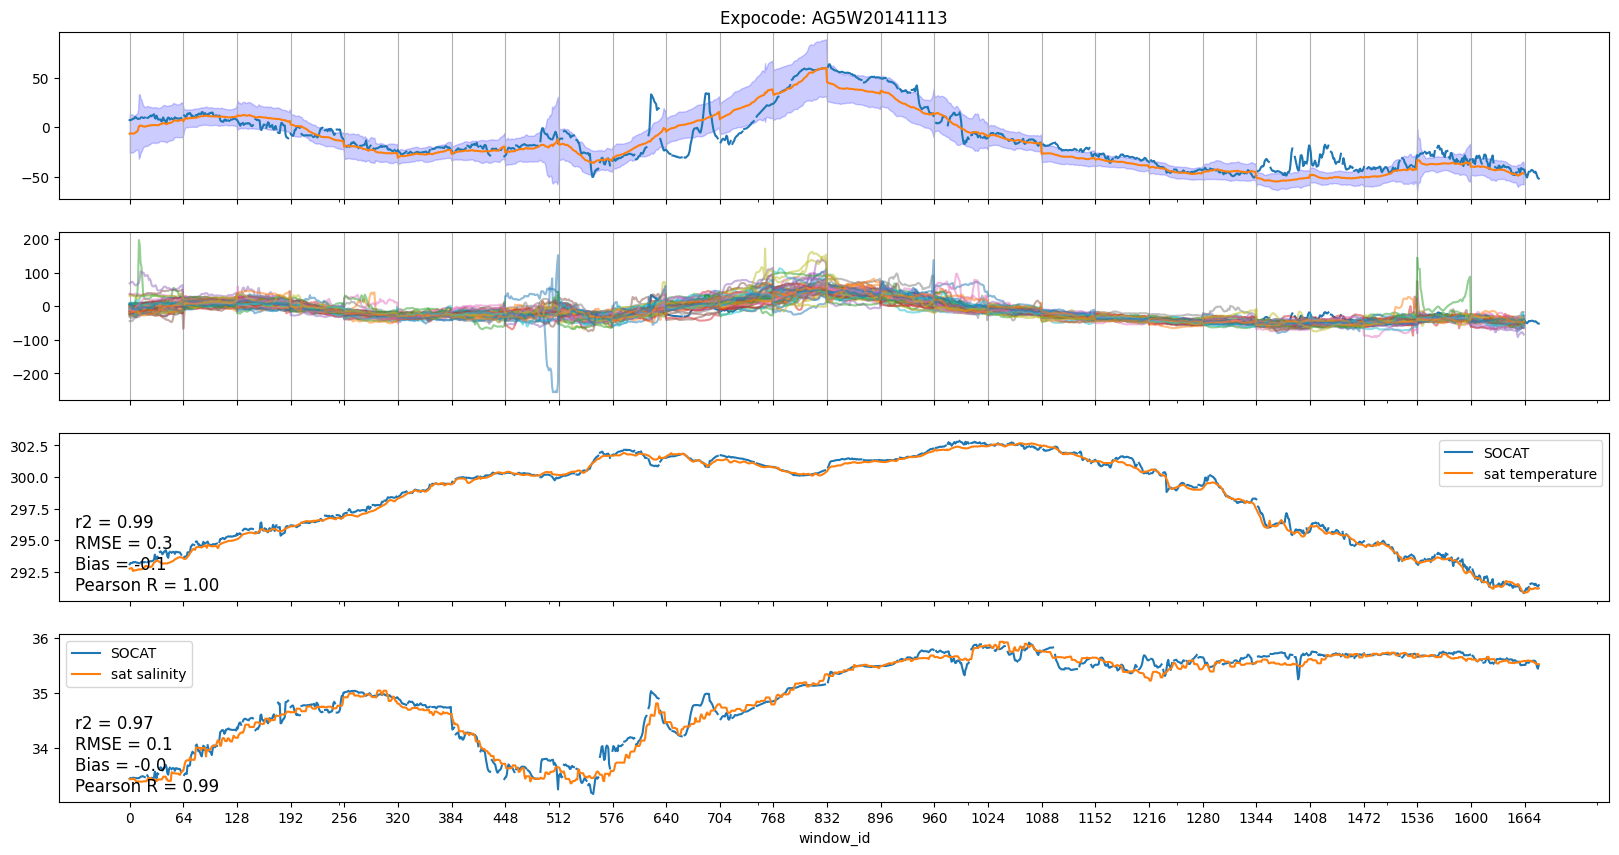

In [42]:
# find unique expocodes in info_df
valid = info_df.groupby('expocode').apply(lambda x: x.predictions.notnull().sum() > 0,  include_groups=False)
expocodes = valid.loc[valid].index
expocode ="AG5W20141113"##
print(f"Expocode: {expocode}")
print(f"Expocode_id: {expocode_map[expocode]}")

info_cols =  pred_columns + ['predictions', 'fco2rec_uatm', 'residuals', 'uncert', 'seamask', 'sst_cci', 'sst_deg_c', 'sss_cci' ,'sal'] 
cruise = info_df.loc[info_df['expocode'] == expocode,  info_cols + ['lat', 'lon', 'window_id']].groupby(['lat', 'lon']).mean()
cruise.set_index(['window_id'], inplace=True)
cruise.sort_index(inplace=True)
fig, axs = plt.subplots(4, 1, figsize=(20, 10), sharex=True, sharey=False, )
axs[0].grid(True, axis='x')
axs[0].set_title(f"Expocode: {expocode}")
plot_diff_samples(axs[0], cruise[pred_columns], cruise['fco2rec_uatm'], True, label='Predictions',)
axs[1].grid(True, axis='x')
plot_diff_samples(axs[1],cruise[pred_columns], cruise['fco2rec_uatm'], False, label='Predictions',)
plot_line_comparison(axs[2], cruise['sst_deg_c'] + 273.15, cruise['sst_cci'], label='sat temperature')
plot_line_comparison(axs[3], cruise['sal'], cruise['sss_cci'], label='sat salinity')

In [43]:
cruise[['fco2rec_uatm', 'predictions']]

,fco2rec_uatm,predictions
window_id,,
0.0,7.151115,-6.585663
1.0,7.043144,-6.106320
2.0,7.623279,-6.296307
3.0,7.839771,-6.500030
4.0,8.491779,-6.577736
...,...,...
1677.0,-44.980020,NaN
1678.0,-46.638285,NaN
1679.0,-49.289530,NaN


# analyse baseline model

In [59]:
import pandas as pd
import numpy as np
from fco2models.utraining import prep_df
val_df = pd.read_parquet('../data/training_data/valdf_100km_xco2.pq')
val_df2021 = pd.read_parquet('../data/training_data/df_100km_xco2_2021.pq')
train_df = pd.read_parquet('../data/training_data/traindf_100km_xco2.pq')

train_df, val_df, val_df2021 = prep_df([train_df, val_df, val_df2021], index=['segment', 'bin'], bound=True)

2025-05-03 19:23:50,549 - INFO - salinity stacking
2025-05-03 19:23:50,895 - INFO - adding positional and temporal encodings
2025-05-03 19:23:55,244 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-05-03 19:23:55,526 - INFO - add climatology data
2025-05-03 19:24:25,388 - INFO - replacing outliers with Nans, fco2rec_uatm > 400
2025-05-03 19:24:26,544 - INFO - salinity stacking
2025-05-03 19:24:26,576 - INFO - adding positional and temporal encodings
2025-05-03 19:24:26,958 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-05-03 19:24:26,998 - INFO - add climatology data
2025-05-03 19:24:40,822 - INFO - replacing outliers with Nans, fco2rec_uatm > 400
2025-05-03 19:24:40,955 - INFO - salinity stacking
2025-05-03 19:24:40,971 - INFO - adding positional and temporal encodings
2025-05-03 19:24:41,123 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-05-03 19:24:41,155 - INFO - add climatology data
2025-05-03 19:24:50,666 - INFO - replacing outlier

In [60]:
from fco2models.models import UNet2DModelWrapper, UNet1DModel
from fco2models.ueval import load_model
import torch
# load baseline model
save_path = '../models/baseline/naivepos/'
model_path = 'e_60.pt'
model_class = UNet2DModelWrapper
model, noise_scheduler, params, losses = load_model(save_path, model_path, model_class)
print("Baseline model loaded")

Baseline model loaded


In [61]:
train_losses = losses['train_losses']
val_losses = losses['val_losses']
# print epoch with minimum loss
print("Epoch with minimum training loss: ", np.argmin(train_losses))
print("Minimum training loss: ", np.min(train_losses))

print("Epoch with minimum validation loss: ", np.argmin(val_losses))
print("Minimum validation loss: ", np.min(val_losses))

Epoch with minimum training loss:  99
Minimum training loss:  0.09788767590863781
Epoch with minimum validation loss:  36
Minimum validation loss:  0.21699580298313362


In [ ]:
from fco2models.utraining import prepare_segment_ds, normalize_dss, get_stats
predictors = params['predictors']
info = ['lat', 'lon', 'day_of_year', 'year', 'expocode']
(train_ds, train_coords), (val_ds, val_coords) = prepare_segment_ds([train_df, val_df], predictors, with_mask=True, info=info)
train_stats = get_stats(train_ds)
# np.random.shuffle(val_ds)
train_ds_norm, val_ds_norm = normalize_dss([train_ds.copy(), val_ds.copy()], train_stats, params['mode'], ignore=[7, 8, 9, 10, 11, 12])
stats = {'train_means': train_stats['means'], 
         'train_stds': train_stats['stds'],
         'train_mins': train_stats['mins'], 
         'train_maxs': train_stats['maxs']
         }
# vald_ds2021 = prep_data(vald_df2021, predictors)
# val_ds = np.concatenate((val_ds, vald_ds2021), axis=0)

print("train_ds shape: ", train_ds.shape)
print("val_ds shape: ", val_ds.shape)

2025-05-03 19:24:51,142 - INFO - info features: ['lat', 'lon', 'day_of_year', 'year', 'expocode']
2025-05-03 19:24:54,564 - INFO - predictors: ['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda', 'xco2', 'sin_day_of_year', 'cos_day_of_year', 'sin_lat', 'sin_lon_cos_lat', 'cos_lon_cos_lat']


Number of samples after filtering:  209343
yX shape: (12, 209343, 64)


2025-05-03 19:25:02,047 - INFO - predictors: ['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda', 'xco2', 'sin_day_of_year', 'cos_day_of_year', 'sin_lat', 'sin_lon_cos_lat', 'cos_lon_cos_lat']


Number of samples after filtering:  22441
yX shape: (12, 22441, 64)


2025-05-03 19:25:07,532 - INFO - Means: [np.float64(-31.85515019522005), np.float64(291.49492360826207), np.float64(32.558164963890555), np.float64(0.6836796394383253), np.float64(0.05670852774367465), np.float64(37.11385439700527), np.float64(392.4558850338762), np.float64(0.6470912102728014), np.float64(0.02198655885396615), np.float64(0.2753931007614051), np.float64(-0.16399171357166006), np.float64(0.07971597452035714), np.float64(0.8040780411812194)]
2025-05-03 19:25:07,532 - INFO - Stds: [np.float64(55.44230006579691), np.float64(9.417746927771578), np.float64(7.516368452649472), np.float64(1.8752586802383828), np.float64(0.10902147425141874), np.float64(56.17053871096368), np.float64(13.507788179586058), np.float64(0.2978493992686017), np.float64(0.7014807879549392), np.float64(0.5414473433774956), np.float64(0.4989884100091686), np.float64(0.5905557233560285), np.float64(0.3969087361993846)]
2025-05-03 19:25:07,532 - INFO - Mins: [np.float64(-391.4479064941406), np.float64(271.

train_ds shape:  (209343, 13, 64)
val_ds shape:  (22441, 13, 64)


In [63]:
assert np.allclose(train_stats['maxs'], params['train_maxs'])
assert np.allclose(train_stats['mins'], params['train_mins'])
assert np.allclose(train_stats['means'], params['train_means'])
assert np.allclose(train_stats['stds'], params['train_stds'])

In [64]:
n_samples = val_ds_norm.shape[0]

In [ ]:
def wrap_and_eval_mean_estimator(s, model, n_samples=50):
    from torch.utils.data import DataLoader, TensorDataset
    from fco2models.umeanest import predict_mean_eval
    if n_samples == None:
        n_samples = s.shape[0]
    s_context = s[:n_samples]
    print("context_ds shape: ", s_context.shape)
    s_context_ds = TensorDataset(torch.from_numpy(s_context).float())
    
    s_context_loader = DataLoader(s_context_ds, batch_size=256, shuffle=False)
    
    with torch.no_grad():
        # denoise the samples
        print("Estimating mean samples")
        losses, s_means_norm = predict_mean_eval(model, s_context_loader)
    return s_means_norm, losses
    

In [ ]:
val_means_norm, val_losses = wrap_and_eval_mean_estimator(val_ds_norm, model, n_samples=None)

context_ds shape:  (22441, 13, 64)
Estimating mean samples
Predicting on cuda


Predicting: 100%|██████████| 88/88 [00:09<00:00,  9.58it/s, Loss=nan]


In [94]:
train_means_norm, train_losses = wrap_and_eval_mean_estimator(train_ds_norm, model, n_samples=None)

context_ds shape:  (209343, 13, 64)
Estimating mean samples
Predicting on cuda


Predicting: 100%|██████████| 818/818 [01:23<00:00,  9.75it/s, Loss=nan]


In [68]:
val_means_norm.shape

(22441, 1, 64)

In [95]:
from fco2models.ueval import get_error_stats, rescale
# calculate the error statistics for the validation set
print("Validation set error stats")
val_means = rescale(
    val_means_norm.copy(), stats, params['mode']
    ).reshape(val_means_norm.shape)
# val_ds_scaled = rescale(
#     val_ds.copy(), stats, params['mode']
#     ).reshape(val_ds.shape)
val_error_dict = get_error_stats(
    val_means, 
    val_ds[:n_samples, 0:1, :]
    )

Validation set error stats
Error statistics:
RMSE: 27.7383
MAE: 16.0325
R2: 0.7363
Bias: -0.2340 ± 21.1543
Mean correlation: 0.2388 ± 0.4617


In [97]:
from fco2models.ueval import get_error_stats, rescale
# get error stats for the training set
print("Training set error stats")
train_means = rescale(
    train_means_norm.copy(), stats, params['mode']
    ).reshape(train_means_norm.shape)
train_error_dict = get_error_stats(
    train_means, 
    train_ds[:, 0:1, :]
    )

Training set error stats
Error statistics:
RMSE: 17.5863
MAE: 11.2075
R2: 0.8994
Bias: -0.3116 ± 10.9017
Mean correlation: 0.3118 ± 0.4434


In [98]:
import matplotlib.pyplot as plt
def plot_preds(preds, ds, ixs, random_preds=None):
    fig, axs = plt.subplots(len(ixs), 1, sharex=True, sharey=True, figsize=(20,len(ixs) * 5))
    for (i, ix) in enumerate(ixs):
        axs[i].plot(preds[ix, 0, :].T, '^-', label='prediction', color='blue', alpha=0.5, linewidth=2)
        axs[i].plot(ds[ix, 0, :].T, 'o-', label='original', color='red', alpha=1, linewidth=2)
        if random_preds is not None:
            axs[i].plot(random_preds[ix, 0, :].T, 'o-', label='random prediction', color='green', alpha=0.5)
        axs[i].set_title(f'Prediction vs original {ix}')
        axs[i].set_xlabel('bins')
        axs[i].set_ylabel('fCO2')

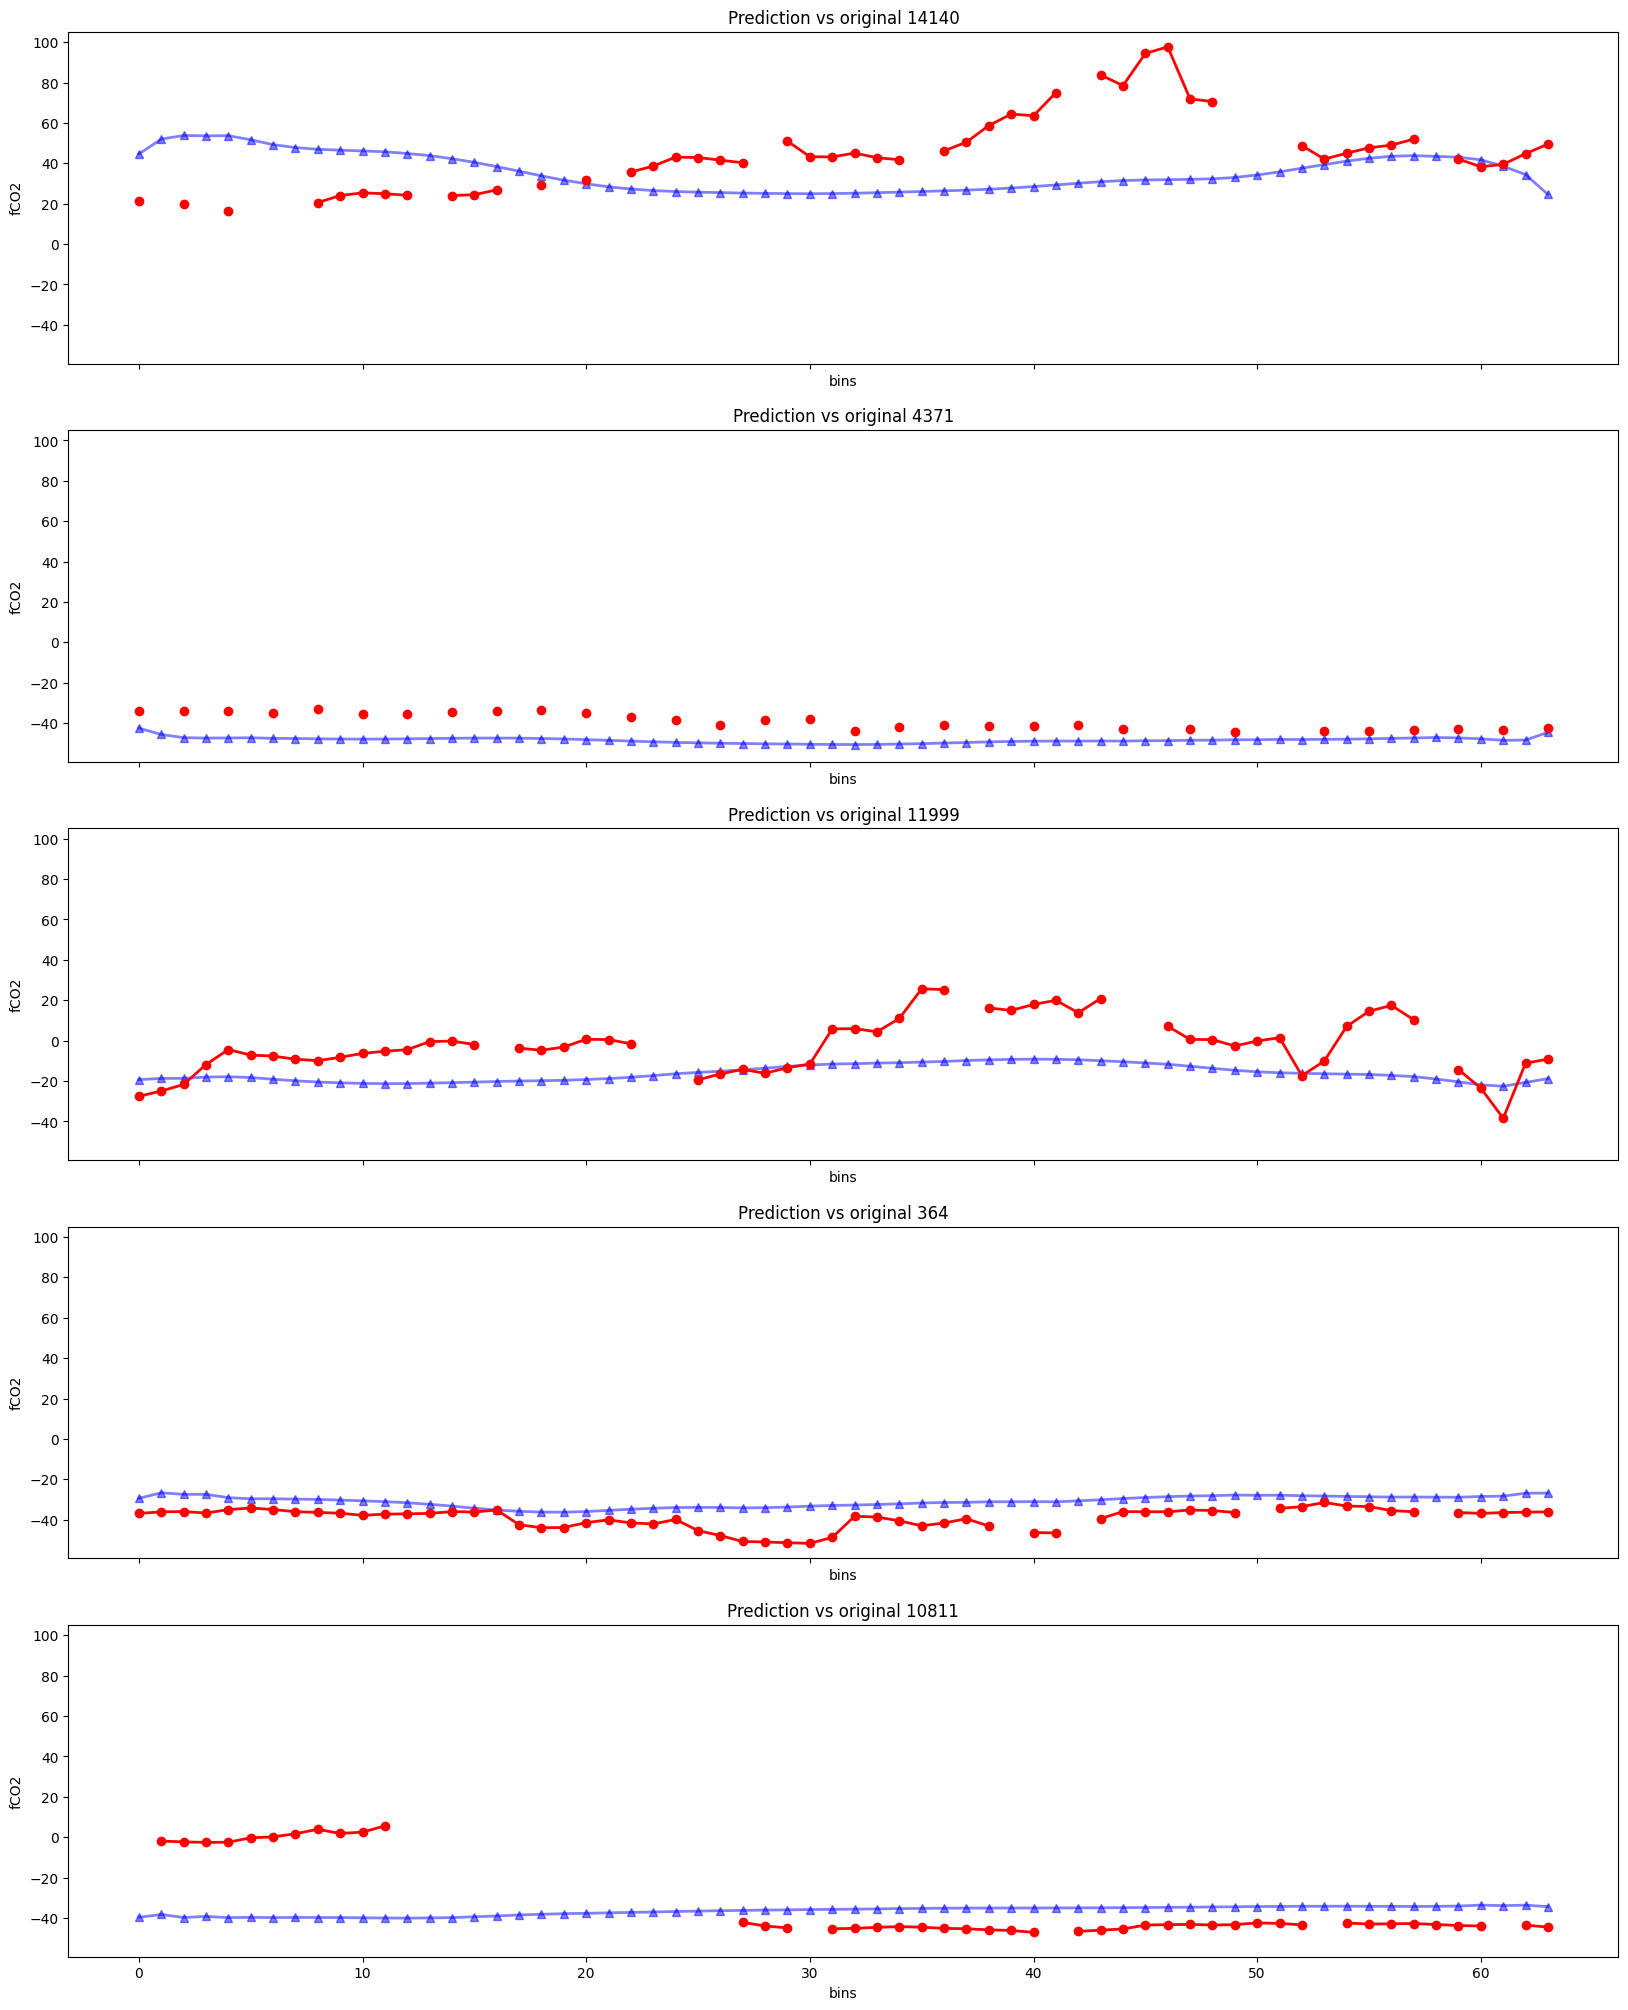

In [99]:
plot_preds(train_means, train_ds[:n_samples], np.random.choice(np.arange(n_samples), size=5, replace=False))

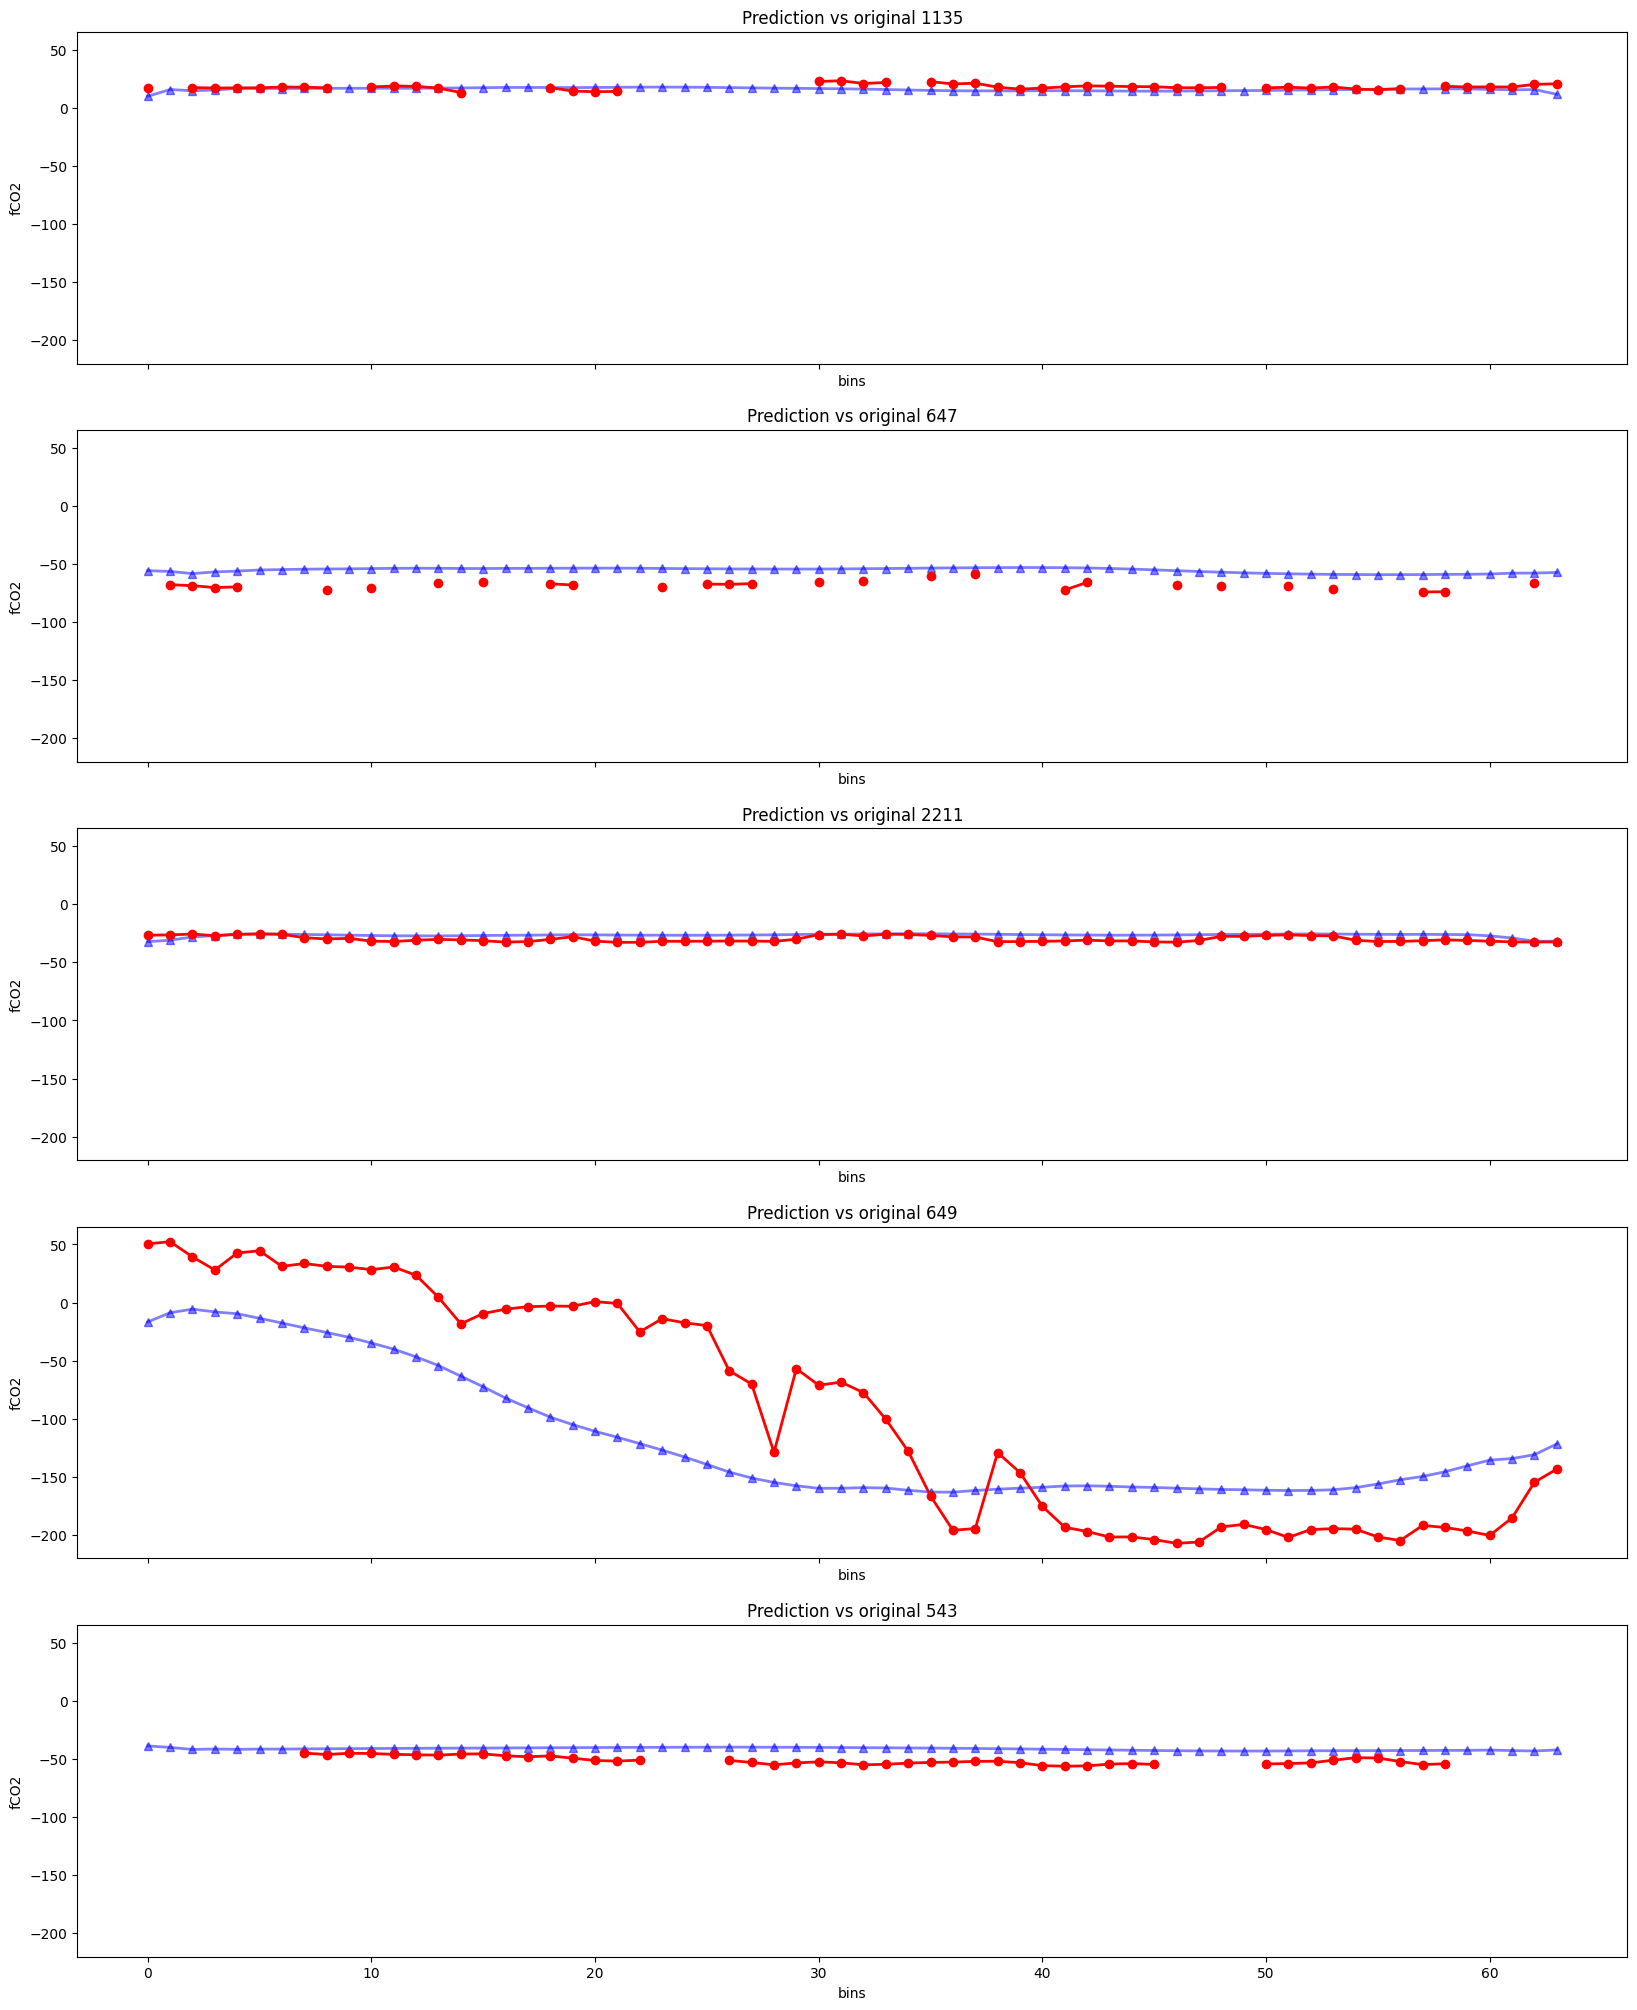

In [100]:
plot_preds(val_means, val_ds[:3000], np.random.choice(np.arange(3000), size=5, replace=False))

In [101]:
def get_info_df(preds, truth, coords, info):
    truth_preds_coords = np.concatenate((truth, preds, coords), axis=1)
    columns = ['fco2'] + [f'sample_{i}' for i in range(preds.shape[1])] + info
    truth_preds_coords_df = pd.DataFrame()
    for i, col in enumerate(columns):
        truth_preds_coords_df[col] = truth_preds_coords[:, i].flatten()
    return truth_preds_coords_df 

In [102]:
np.concatenate([val_means, train_means], axis=0).shape

(231784, 1, 64)

In [120]:
info = ['lat', 'lon', 'day_of_year', 'year', 'expocode']
info_df = get_info_df(
    np.concatenate([val_means, train_means], axis=0),
    np.concatenate([val_ds[:, 0:1, :], train_ds[:, 0:1, :]], axis=0),
    np.concatenate([val_coords, train_coords], axis=0),
    info)

In [121]:
info_df.head()

,fco2,sample_0,lat,lon,day_of_year,year,expocode
0,NaN,34.014584,10.665000,-125.195007,277.0,1997.0,430.0
1,26.631178,30.642115,10.623333,-125.206665,277.0,1997.0,430.0
2,26.800179,28.562391,10.585000,-125.220001,277.0,1997.0,430.0
3,27.555845,27.438208,10.543334,-125.236679,277.0,1997.0,430.0
4,28.614677,26.830507,10.500000,-125.250000,277.0,1997.0,430.0


In [124]:
group_cols = ['lat', 'lon']
info_df['predictions'] = info_df.iloc[:, 1]
info_df['residuals'] = info_df['predictions'] - info_df['fco2']
# round group_cols to int
info_df[group_cols] = (info_df[group_cols] * 8).round(0) / 8.0
plotting_data = info_df.loc[:, group_cols + ['predictions', 'fco2', 'residuals']].groupby(group_cols).mean().to_xarray().coarsen(lat=10, lon=10, boundary='pad').mean()

(np.float64(-180.0625),
 np.float64(180.625),
 np.float64(-78.5625),
 np.float64(82.4375))

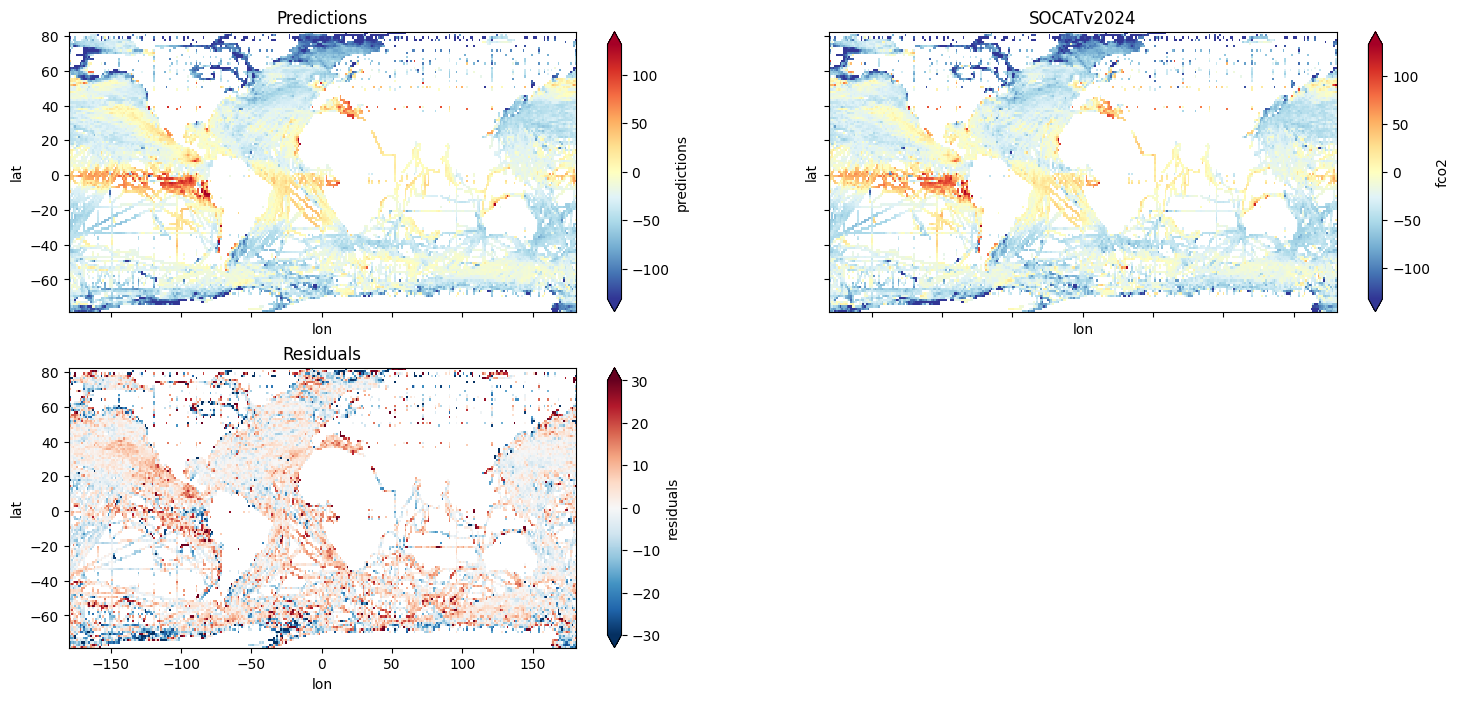

In [125]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(18, 8), sharex=True, sharey=True)
plotting_data.predictions.plot.imshow(robust=True, ax=axs[0, 0], cmap='RdYlBu_r',)
axs[0, 0].set_title('Predictions')
plotting_data.fco2.plot.imshow(robust=True, ax=axs[0, 1], cmap='RdYlBu_r')
axs[0, 1].set_title('SOCATv2024')
plotting_data.residuals.plot.imshow(robust=True, ax=axs[1, 0], cmap='RdBu_r', vmin=-30, vmax=30)
axs[1, 0].set_title('Residuals')
axs[1, 1].axis('off')

In [ ]:
# save the figure in the save_path
fig.savefig(save_path+f'predictions_{model_path}.png', dpi=300, bbox_inches='tight')